In [1]:
import pandas as pd

try:
    #reading files
    perm_assign_df = pd.read_csv('Azure_Permission_Assignment.csv')
    user_assign_df = pd.read_csv('Azure_User_Assignment.csv')

    # FIXING UA NAMES: Rename 'UserPrincipalName' to 'User' in user_assign_df
    user_assign_df = user_assign_df.rename(columns={'UserPrincipalName': 'User'})
    user_assign_df = user_assign_df.rename(columns={'DirectoryRoles': 'Role'})

    # FIXING PA NAMES: Rename 'permission(action)' to 'Permission' in perm_assign_df and 'role' to 'Role' in perm_assign_df to match user_assign_df_tidy for merging
    perm_assign_df = perm_assign_df.rename(columns={'permission(action)': 'Permission'})
    perm_assign_df = perm_assign_df.rename(columns={'role': 'Role'})

    user_assign_df['Role'] = user_assign_df['Role'].str.split(',')
    user_assign_df_tidy = user_assign_df.explode('Role')

    # Clean up any extra whitespace from the role names after exploding
    user_assign_df_tidy['Role'] = user_assign_df_tidy['Role'].str.strip()


    # Step 4: Merge the tidy user data with the permission data
    merged_df = pd.merge(user_assign_df_tidy, perm_assign_df, on='Role')


    # Step 5: Create the final UPA matrix
    upa_matrix = pd.crosstab(merged_df['User'], merged_df['Permission']).clip(upper=1)

    # Save the matrix to a file
    upa_matrix.to_csv('UPA_Matrix.csv')

except FileNotFoundError:
    print("Error: Make sure 'Azure_Permission_Assignment.csv' and 'Azure_User_Assignment.csv' are in the correct directory.")
#except Exception as e:
#    print(f"An error occurred: {e}")

print("Actual number of roles is", len(perm_assign_df['Role'].unique()))

Actual number of roles is 115


In [2]:
temp_df=perm_assign_df[['Permission', 'description']]
temp_df=temp_df.drop_duplicates(subset=['description'])
temp_df.to_csv('PermsToDesc.csv')

#print(len(temp_df))

In [3]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from itertools import combinations
import matplotlib.pyplot as plt
from typing import Dict, Set, List

# --- Core Algorithm 1: FastMiner ---
def fast_miner(upa: Dict[str, Set[str]]) -> List[frozenset[str]]:
    """
    Implements the FastMiner algorithm (Algorithm 2) to generate candidate roles.
    """
    init_roles = {frozenset(perms) for perms in upa.values() if perms}
    gen_roles = set()
    for role1, role2 in combinations(init_roles, 2):
        intersection = role1.intersection(role2)
        if intersection:
            gen_roles.add(intersection)
    return list(init_roles.union(gen_roles))

# --- Core Algorithm 2: delta-Approx RMP ---
def delta_approx_rmp(upa: Dict[str, Set[str]], delta: float, verbose: bool = True) -> List[frozenset[str]]:
    """
    Implements the delta-Approximate Role Mining Problem (Algorithm 3).
    """
    if not upa:
        return []

    candidate_roles = fast_miner(upa)
    upa_entries = {(user, perm) for user, perms in upa.items() for perm in perms}
    total_upa_entries = len(upa_entries)

    if total_upa_entries == 0:
        return []

    target_coverage = total_upa_entries * (1.0 - delta)
    role_areas = {}
    for role in candidate_roles:
        support_count = sum(1 for user_perms in upa.values() if role.issubset(user_perms))
        role_areas[role] = len(role) * support_count

    sorted_candidates = sorted(
        candidate_roles,
        key=lambda r: role_areas.get(r, 0),
        reverse=True
    )

    final_roles = []
    covered_entries = set()
    iteration_num = 1

    while len(covered_entries) < target_coverage:
        best_role, best_uncovered_area = None, -1

        for candidate in sorted_candidates:
            if role_areas.get(candidate, 0) <= best_uncovered_area:
                break

            current_role_entries = {
                (user, perm) for user, perms in upa.items()
                if candidate.issubset(perms) for perm in candidate
            }
            uncovered = current_role_entries - covered_entries

            if len(uncovered) > best_uncovered_area:
                best_uncovered_area = len(uncovered)
                best_role = candidate

        if best_role is None or best_uncovered_area == 0:
            if verbose: print("    - No more permissions can be covered. Stopping cluster.")
            break

        final_roles.append(best_role)
        best_role_entries = {
            (user, perm) for user, perms in upa.items()
            if best_role.issubset(perms) for perm in best_role
        }
        covered_entries.update(best_role_entries)
        sorted_candidates.remove(best_role)

        if verbose:
            coverage_percent = (len(covered_entries) / total_upa_entries) * 100
            print(f"    - Iteration {iteration_num}: Picked role {set(best_role)}, Coverage: {coverage_percent:.2f}%")
        iteration_num += 1

    return final_roles

In [4]:
def generate_permission_vectors(permission_df: pd.DataFrame) -> Dict[str, np.ndarray]:
    """
    Converts permission descriptions into semantic vectors using SBERT
    Args:
        permission_df: A pandas DataFrame with 'Permission' and 'description' columns.
    Returns:
        A dictionary {permission_name: embedding_vector}
    """
    print("[Phase 1] Generating semantic vectors for permissions...")

    model = SentenceTransformer('all-MiniLM-L6-v2')
    permissions = permission_df['Permission'].tolist()
    descriptions = permission_df['description'].tolist()

    # Generate the embeddings
    permission_vectors = model.encode(descriptions)

    # Create a mapping dictionary
    vector_dict = {perm: vec for perm, vec in zip(permissions, permission_vectors)}
    print("✓ [Phase 1] Vectors generated successfully.\n")
    return vector_dict

In [5]:

# SECTION 4: PHASE 2 - SEMANTIC CLUSTERING (Drawing Boundaries)


def find_optimal_k(vectors: np.ndarray, max_k: int = 10) -> None:
    """
    Calculates and plots the inertia (WCSS) for a range of k values
    to help find the "elbow" in a K-Means plot.

    Args:
        vectors: A 2D numpy array of permission vectors.
        max_k: The maximum number of clusters to test.
    """
    print("[Phase 2a] Calculating inertia to find optimal 'k' (Elbow Method)...")
    inertias = []
    # Ensure max_k is not > num_samples
    k_range = range(1, min(max_k + 1, len(vectors)))

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(vectors)
        inertias.append(kmeans.inertia_)

    # Plot the elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (WCSS)')
    plt.title('K-Means Elbow Method for Optimal k')
    plt.grid(True)
    plt.xticks(list(k_range))
    plt.show()
    print("✓ [Phase 2a] Elbow plot displayed. Please choose an optimal 'k'.\n")


def cluster_permissions(permission_vectors: Dict[str, np.ndarray], num_clusters: int) -> List[Set[str]]:
    """
    Clusters permissions into semantic groups using K-Means.

    Args:
        permission_vectors: The dictionary {permission_name: vector}
        num_clusters: The chosen 'k' value.

    Returns:
        A list of clusters, where each cluster is a set of permission names.
    """
    print(f"[Phase 2b] Clustering permissions into {num_clusters} semantic groups...")
    permissions = list(permission_vectors.keys())
    vectors = np.array([permission_vectors[p] for p in permissions])

    # Run K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
    kmeans.fit(vectors)

    # Organize the permissions into cluster-based sets
    clusters = [set() for _ in range(num_clusters)]
    for permission, label in zip(permissions, kmeans.labels_):
        clusters[label].add(permission)

    print("✓ [Phase 2b] Permissions clustered successfully.\n")
    return clusters

In [6]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from itertools import combinations
import matplotlib.pyplot as plt
from typing import Dict, Set, List


# SECTION 5: PHASE 3 - PARTITIONED ROLE MINING (The Orchestrator)


def semantic_role_miner(upa_df: pd.DataFrame,
                        descriptions_df: pd.DataFrame,
                        num_clusters: int,
                        delta: float = 0.0) -> List[frozenset[str]]:
    """
    Main orchestrator for the semantic role mining process.

    Args:
        upa_df: The complete User-Permission Assignment as a pandas DataFrame
                (users as index, permissions as columns, 0/1 values).
        descriptions_df: A pandas DataFrame with 'Permission' and 'description' columns.
        num_clusters: The chosen 'k' for clustering.
        delta: The coverage threshold for delta-Approx RMP.

    Returns:
        A list of all final, coherent roles discovered.
    """
    # Convert UPA DataFrame to dictionary format (User -> Set[Permissions])
    upa = {}
    for user_id, row in upa_df.iterrows():
        permissions_for_user = set(row[row == 1].index.tolist()) # Columns are permissions
        if permissions_for_user:
            upa[user_id] = permissions_for_user

    # === Calls Phase 1 ===
    perm_vectors_dict = generate_permission_vectors(descriptions_df)

    # === Calls Phase 2 ===
    semantic_clusters = cluster_permissions(perm_vectors_dict, num_clusters)

    print("[Phase 3] Running Partitioned Role Mining (FastMiner on each cluster)..." + "\n" + "="*70)
    all_final_roles = []

    # === Executes Phase 3 ===
    for i, cluster in enumerate(semantic_clusters):
        print(f"\nProcessing Cluster {i+1} / {num_clusters}: {cluster}")

        # 1. Filter the main UPA to only include permissions from this cluster
        filtered_upa = {}
        for user, perms in upa.items():
            user_perms_in_cluster = perms.intersection(cluster)
            # Only add users who have permissions in this cluster
            if user_perms_in_cluster:
                filtered_upa[user] = user_perms_in_cluster

        if not filtered_upa:
            print("  No users have permissions in this cluster. Skipping.")
            continue

        # 2. Run the core mining \"engine\" on this filtered, coherent dataset
        print(f"  Found {len(filtered_upa)} users with permissions in this cluster. Mining roles...")
        roles_in_cluster = delta_approx_rmp(filtered_upa, delta, verbose=True)

        if roles_in_cluster:
            all_final_roles.extend(roles_in_cluster)
            print(f"  ✓ Discovered {len(roles_in_cluster)} roles in this cluster.")
        else:
            print("  No significant roles discovered in this cluster.")

    return all_final_roles

[Phase 1] Generating semantic vectors for permissions...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ [Phase 1] Vectors generated successfully.

[Phase 2a] Calculating inertia to find optimal 'k' (Elbow Method)...


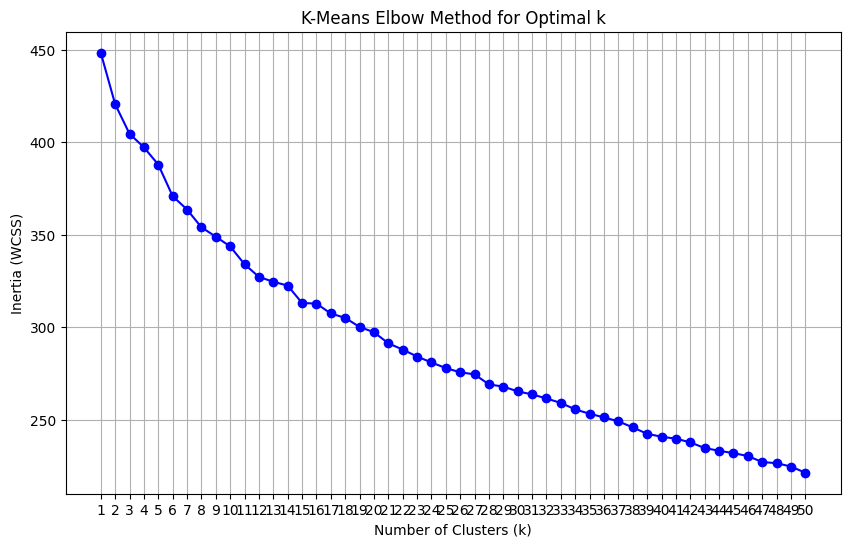

✓ [Phase 2a] Elbow plot displayed. Please choose an optimal 'k'.


Based on the elbow plot, we are proceeding with k = 5

[Phase 1] Generating semantic vectors for permissions...
✓ [Phase 1] Vectors generated successfully.

[Phase 2b] Clustering permissions into 5 semantic groups...
✓ [Phase 2b] Permissions clustered successfully.

[Phase 3] Running Partitioned Role Mining (FastMiner on each cluster)...

Processing Cluster 1 / 5: {'microsoft.directory/users/licenseDetails/read', 'microsoft.directory/servicePrincipals/memberOf/read', 'microsoft.directory/servicePrincipals/owners/read', 'microsoft.directory/users/manager/read', 'microsoft.directory/deviceTemplates/owners/read', 'microsoft.directory/users/invitedBy/read', 'microsoft.directory/users/registeredDevices/read', 'microsoft.directory/users/enable', 'microsoft.directory/users/create', 'microsoft.directory/pendingExternalUserProfiles/create', 'microsoft.directory/b2cUserFlow/allProperties/allTasks', 'microsoft.directory/applicatio

In [7]:
PA = pd.read_csv('Azure_Permission_Assignment.csv')
UA = pd.read_csv('Azure_User_Assignment.csv')
PD = pd.read_csv('PermsToDesc.csv')
UPA = pd.read_csv('UPA_Matrix.csv')

# 2. Find Optimal 'k' (Optional but Recommended)
# We do this once to analyze our permission set.
temp_vectors_dict = generate_permission_vectors(PD)
temp_vectors_array = np.array(list(temp_vectors_dict.values()))

# Check up to 50 clusters
find_optimal_k(temp_vectors_array, max_k=50)

# After viewing the plot, you choose the 'k' at the elbow.
# For this dataset, the elbow is clearly at k=6.
CHOSEN_K = 5
print(f"\nBased on the elbow plot, we are proceeding with k = {CHOSEN_K}\n")


# --- 3. Run the Full Semantic Miner ---
# This single function call runs the entire process
discovered_roles = semantic_role_miner(
    upa_df=UPA,
    descriptions_df=PD,
    num_clusters=CHOSEN_K,
    delta=0.0 # Aim for 100% coverage in each cluster
)

# --- 4. Print Final Results ---
print("\n" + "="*70 + "\nFinal Discovered Semantic Roles (All Clusters):")
if discovered_roles:
    for i, role in enumerate(discovered_roles):
        print(f"  Role {i+1}: {set(role)}")
else:
    print("No roles were discovered.")

In [8]:
print(discovered_roles)

[frozenset({'microsoft.virtualVisits/allEntities/allProperties/read', 'microsoft.directory/externalUserProfiles/standard/read', 'microsoft.directory/scopedRoleMemberships/allProperties/read'}), frozenset({'microsoft.directory/users/restore', 'microsoft.directory/users/disable', 'microsoft.directory/users/sponsors/update', 'microsoft.directory/users/assignLicense', 'microsoft.directory/users/password/update', 'microsoft.directory/users/enable', 'microsoft.directory/users/convertExternalToInternalMemberUser', 'microsoft.directory/users/photo/update', 'microsoft.directory/users/create', 'microsoft.directory/users/usageLocation/update', 'microsoft.directory/users/lifeCycleInfo/read', 'microsoft.directory/users/delete', 'microsoft.directory/users/inviteGuest', 'microsoft.directory/deletedItems.users/restore'}), frozenset({'microsoft.directory/users/restore', 'microsoft.directory/users/disable', 'microsoft.directory/users/enable', 'microsoft.directory/users/delete', 'microsoft.directory/dele

**Reasoning**:
To reconstruct the original role permissions, I will group the `perm_assign_df` by 'Role', collect unique 'Permission' values into a set for each role, convert these sets to frozensets, and store them in a set named `original_roles_set` for efficient comparison.



In [9]:
grouped_permissions = perm_assign_df.groupby('Role')['Permission'].apply(lambda x: frozenset(x.unique()))
original_roles_set = set(grouped_permissions.tolist())

print(f"Reconstructed {len(original_roles_set)} original roles based on their permission sets.")

Reconstructed 115 original roles based on their permission sets.


**Reasoning**:
Now that the original roles have been reconstructed, the next step is to compare these with the roles discovered by the semantic miner. This involves converting `discovered_roles` to a set for efficient lookup, counting exact matches, and then summarizing the comparison.



In [10]:
discovered_roles_set = set(discovered_roles)

exact_matches_count = 0
for original_role_perms in original_roles_set:
    if original_role_perms in discovered_roles_set:
        exact_matches_count += 1

total_original_roles = len(original_roles_set)
total_discovered_roles = len(discovered_roles_set)

print("="*70)
print("Comparison of Original Roles vs. Discovered Semantic Roles")
print("="*70)
print(f"Total Unique Original Roles: {total_original_roles}")
print(f"Total Unique Discovered Roles (from semantic miner): {total_discovered_roles}")
print(f"Number of Original Roles Exactly Matched by Discovered Roles: {exact_matches_count}")
print("="*70)

print("\nComprehensive Summary:")
if exact_matches_count == total_original_roles and total_original_roles == total_discovered_roles:
    print("The semantic role miner perfectly reconstructed all original roles, with no additional roles discovered.")
elif exact_matches_count == total_original_roles and total_discovered_roles > total_original_roles:
    print(f"All {total_original_roles} original roles were exactly matched by the semantic role miner. Additionally, the miner identified {total_discovered_roles - total_original_roles} new distinct roles.")
elif exact_matches_count > 0:
    print(f"The semantic role miner identified {exact_matches_count} roles that are exact matches to the original roles. This indicates a good level of fidelity for these specific roles. However, there are {total_original_roles - exact_matches_count} original roles not exactly matched and {total_discovered_roles - exact_matches_count} unique discovered roles that do not correspond to an original role.")
else:
    print("No exact matches were found between the original roles and the roles discovered by the semantic role miner. This suggests that the miner is either creating more granular roles, or the semantic clustering significantly altered the role structures.")

Comparison of Original Roles vs. Discovered Semantic Roles
Total Unique Original Roles: 115
Total Unique Discovered Roles (from semantic miner): 86
Number of Original Roles Exactly Matched by Discovered Roles: 2

Comprehensive Summary:
The semantic role miner identified 2 roles that are exact matches to the original roles. This indicates a good level of fidelity for these specific roles. However, there are 113 original roles not exactly matched and 84 unique discovered roles that do not correspond to an original role.


In [11]:
# --- New Cell: Best-Match Analysis (Discovered vs. Original) ---
# For every role my algorithm invented, does it look like a real role?

import numpy as np
import pandas as pd

# Helper function for Jaccard Similarity (if not already defined in another cell)
def jaccard_similarity(set1, set2):
    """
    Calculates the Jaccard similarity between two sets.
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))

    if union == 0:
        return 1.0

    return intersection / union

# --- Best-Match Analysis (Discovered vs. Original) ---
# Answers: "What original role does my new discovered role most look like?"

print("--- Starting Best-Match Analysis (Discovered vs. Original) ---")

best_match_scores = []
best_match_results = []

# 1. Iterate through each of the 90 *discovered roles*
for i, discovered_role in enumerate(discovered_roles_set):

    best_score = -1.0
    best_original_role = None

    # 2. Compare it against all 115 *original roles*
    for original_role in original_roles_set:
        score = jaccard_similarity(discovered_role, original_role)

        if score > best_score:
            best_score = score
            best_original_role = original_role

    # 3. Store the best match found for this discovered role
    best_match_scores.append(best_score)
    best_match_results.append({
        'discovered_role_id': i,
        'best_match_score': best_score,
        'discovered_role_size': len(discovered_role),
        'best_original_role_size': len(best_original_role) if best_original_role else 0
    })

# --- Summarize and Print the Results ---
if best_match_scores:
    avg_best_match_score = np.mean(best_match_scores)

    # Count how many discovered roles are a strong match to an original role
    strong_matches = sum(1 for s in best_match_scores if s > 0.75)

    # Count how many are perfect subsets of an original role
    # This is a very good sign: finding the "core"
    subset_matches = 0
    for dr in discovered_roles_set:
        for or_ in original_roles_set:
            if dr.issubset(or_):
                subset_matches += 1
                break # Count each discovered role only once

    total_discovered_roles = len(discovered_roles_set)

    print("="*70)
    print("Best-Match Analysis Results (Discovered vs. Original)")
    print("="*70)
    print(f"Total Discovered Roles Analyzed: {total_discovered_roles}")
    print("\n--- Final Score ---")
    print(f"Average Best-Match Jaccard Score: {avg_best_match_score:.4f}")
    print("\n--- Detailed Statistics ---")
    print(f"Discovered Roles with a Strong Match (Score > 0.75): {strong_matches} / {total_discovered_roles}")
    print(f"Discovered Roles that are perfect subsets of an Original Role: {subset_matches} / {total_discovered_roles}")
    print("="*70)

    # Optional: Display a few of the best matches
    # You can sort by 'best_match_score' descending
    # results_df = pd.DataFrame(best_match_results)
    # print("\nTop 10 Best Matches Found:")
    # print(results_df.sort_values(by='best_match_score', ascending=False).head(10))

else:
    print("No best-match scores were calculated. 'discovered_roles_set' might be empty.")

--- Starting Best-Match Analysis (Discovered vs. Original) ---
Best-Match Analysis Results (Discovered vs. Original)
Total Discovered Roles Analyzed: 86

--- Final Score ---
Average Best-Match Jaccard Score: 0.4003

--- Detailed Statistics ---
Discovered Roles with a Strong Match (Score > 0.75): 5 / 86
Discovered Roles that are perfect subsets of an Original Role: 71 / 86


Disc. Role ID   | Best Match Precision   | Recall (Coverage)   
-----------------------------------------------------------------
0                                                                                          | 1.00                   | 0.48                
1                                                                                          | 1.00                   | 0.33                
2                                                                                          | 1.00                   | 0.21                
3                                                                                          | 1.00                   | 0.05                
4                                                                                          | 1.00                   | 0.78                
5                                                                                          | 0.62                   | 0.08                
6                                   

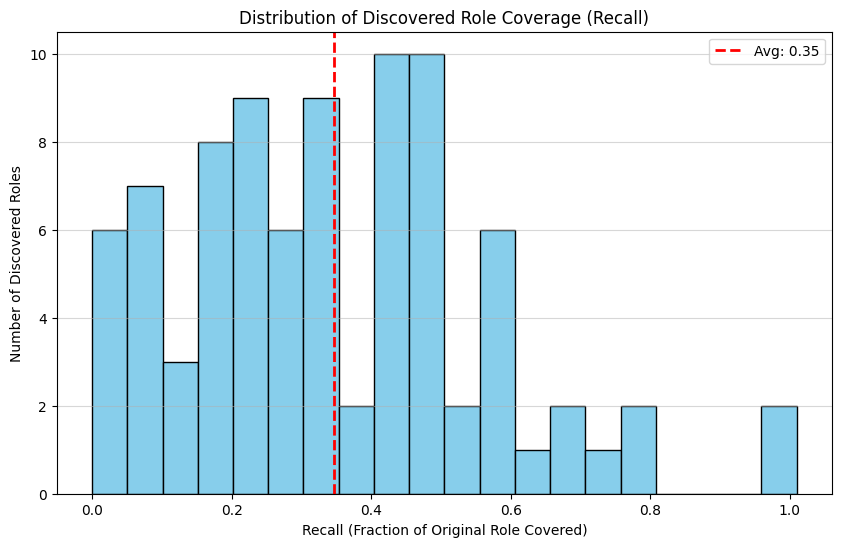

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Ensure Data Structures Exist ---
# We check if the necessary variables from previous cells exist.
if 'discovered_roles' in locals():
    discovered_roles_set = set(discovered_roles)
else:
    print("Warning: 'discovered_roles' not found. Please run the miner function first.")
    discovered_roles_set = set()

if 'original_roles_set' not in locals():
    # Attempt to reconstruct if missing (assuming perm_assign_df exists from cell 1)
    if 'perm_assign_df' in locals():
        print("Reconstructing 'original_roles_set' from perm_assign_df...")
        grouped_permissions = perm_assign_df.groupby('Role')['Permission'].apply(lambda x: frozenset(x.unique()))
        original_roles_set = set(grouped_permissions.tolist())
    else:
        # Fallback: Try to load the CSV if variable is missing but file exists
        try:
            perm_assign_df = pd.read_csv('Azure_Permission_Assignment.csv')
            # FIX NAMES if needed (based on notebook logic)
            perm_assign_df = perm_assign_df.rename(columns={'permission(action)': 'Permission', 'role': 'Role'})

            print("Loaded perm_assign_df and reconstructing 'original_roles_set'...")
            grouped_permissions = perm_assign_df.groupby('Role')['Permission'].apply(lambda x: frozenset(x.unique()))
            original_roles_set = set(grouped_permissions.tolist())
        except Exception as e:
            print(f"Warning: 'original_roles_set' could not be reconstructed. Error: {e}")
            original_roles_set = set()

# --- 2. Define the Metric Function ---
def calculate_coverage_metrics(discovered_role, original_role):
    """
    Calculates Precision (Purity) and Recall (Coverage) for a pair of roles.
    """
    intersection = len(discovered_role.intersection(original_role))
    len_discovered = len(discovered_role)
    len_original = len(original_role)

    # Precision (Purity): Of the permissions we found, how many are 'correct'?
    precision = intersection / len_discovered if len_discovered > 0 else 0.0

    # Recall (Coverage): How much of the original role did we capture?
    recall = intersection / len_original if len_original > 0 else 0.0

    return precision, recall

# --- 3. Run Analysis Loop ---
print(f"{'Disc. Role ID':<15} | {'Best Match Precision':<22} | {'Recall (Coverage)':<20}")
print("-" * 65)

coverage_scores = []

# Iterate through each discovered role
for i, disc_role in enumerate(discovered_roles_set):
    best_precision = -1.0
    final_recall = 0.0

    # Compare this discovered role against ALL original roles to find its "parent"
    for orig_role in original_roles_set:
        prec, rec = calculate_coverage_metrics(disc_role, orig_role)

        # Strategy: Find the match with the highest Precision (Purity).
        # If a discovered role is 100% pure (Precision=1.0) relative to an Original Role,
        # that Original Role is likely its "parent", so we record the coverage (Recall) for that pair.
        if prec > best_precision:
            best_precision = prec
            final_recall = rec
        elif prec == best_precision:
            # Tie-breaker: If precision is identical, assume it belongs to the role it covers more of.
            if rec > final_recall:
                final_recall = rec

    coverage_scores.append(final_recall)

    # Print first 15 rows to verify data
    if i < 90:
        print(f"{i:<90} | {best_precision:<22.2f} | {final_recall:<20.2f}")

# --- 4. Summary Statistics & Visualization ---
if coverage_scores:
    avg_coverage = np.mean(coverage_scores)

    print("-" * 65)
    print(f"Average Role Coverage (Recall): {avg_coverage:.4f}")
    print(f"(Interpretation: On average, a discovered role covers {avg_coverage*100:.1f}% of its parent original role)")

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(coverage_scores, bins=20, range=(0, 1.01), edgecolor='black', color='skyblue')
    plt.title('Distribution of Discovered Role Coverage (Recall)')
    plt.xlabel('Recall (Fraction of Original Role Covered)')
    plt.ylabel('Number of Discovered Roles')
    plt.axvline(avg_coverage, color='red', linestyle='dashed', linewidth=2, label=f'Avg: {avg_coverage:.2f}')
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.show()
else:
    print("No roles to analyze.")

In [14]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
# --- PRE-REQUISITE: Generate Vectors for Evaluation ---
# Ensure your Permission Description (PD) dataframe is loaded
if 'PD' not in locals():
    PD = pd.read_csv('PermsToDesc.csv')

# Re-generate the vectors and store them in a global variable
print("Re-generating permission vectors for evaluation...")
perm_vectors_dict = generate_permission_vectors(PD)
print("Vectors ready.")
# ---------------------------------------------------------
# 1. Semantic Cohesion
# ---------------------------------------------------------
def calculate_semantic_cohesion(role, vector_dict):
    """
    Calculates average cosine similarity of all pairs of permissions in a role.
    """
    perms = list(role)
    if len(perms) < 2:
        return 1.0 # Single permission roles are perfectly cohesive

    # Get vectors for permissions in this role
    # Safety check: only get vectors for permissions that exist in our dictionary
    vectors = [vector_dict[p] for p in perms if p in vector_dict]

    if len(vectors) < 2:
        return 0.0

    # Calculate similarity matrix
    sim_matrix = cosine_similarity(vectors)

    # Get upper triangle indices (excluding diagonal self-matches)
    upper_tri = sim_matrix[np.triu_indices(len(sim_matrix), k=1)]

    return np.mean(upper_tri)

# ---------------------------------------------------------
# EXECUTION
# ---------------------------------------------------------

# We need to convert the UPA DataFrame into a Dictionary {user: {perm1, perm2}}
print("Converting UPA DataFrame to Dictionary...")
upa_dict_calc = {}
# Assuming 'UPA' is your dataframe from previous cells
for user_id, row in UPA.iterrows():
    # Get column names where value is 1
    perms = set(row[row == 1].index.tolist())
    if perms:
        upa_dict_calc[user_id] = perms

# Calculate Semantic Cohesion
# We need the vector dictionary. Assuming 'perm_vectors_dict' exists from Phase 1.
if 'perm_vectors_dict' in locals():
    cohesion_scores = []
    for role in discovered_roles:
        score = calculate_semantic_cohesion(role, perm_vectors_dict)
        cohesion_scores.append(score)

    avg_cohesion = np.mean(cohesion_scores)
    print(f"--- Semantic Evaluation ---")
    print(f"Average Semantic Cohesion: {avg_cohesion:.4f} (Range -1.0 to 1.0)")
    print(f"  > 1.0 means perfect semantic match (rare)")
    print(f"  > 0.5 usually implies strong thematic grouping")
else:
    print("Warning: 'perm_vectors_dict' not found. Skipping semantic cohesion calculation.")

Re-generating permission vectors for evaluation...
[Phase 1] Generating semantic vectors for permissions...
✓ [Phase 1] Vectors generated successfully.

Vectors ready.
Converting UPA DataFrame to Dictionary...
--- Semantic Evaluation ---
Average Semantic Cohesion: 0.4712 (Range -1.0 to 1.0)
  > 1.0 means perfect semantic match (rare)
  > 0.5 usually implies strong thematic grouping
